In [2]:
# 自动计算cell的计算时间
%load_ext autotime

%matplotlib inline
%config InlineBackend.figure_format='svg' #矢量图设置，让绘图更清晰

time: 423 ms (started: 2021-08-25 23:15:29 +08:00)


In [4]:
%%bash

# 增加更新
git add *.ipynb *.md

git remote -v

git commit -m '更新 #3  Aug 25, 2021'

#git push origin master
git push

origin	git@github.com:ustchope/keras_developer_guides-.git (fetch)
origin	git@github.com:ustchope/keras_developer_guides-.git (push)
[main a0da139] 更新 #3  Aug 25, 2021
 2 files changed, 823 insertions(+), 750 deletions(-)
 create mode 100644 "\344\273\216\345\244\264\345\274\200\345\247\213\347\274\226\345\206\231\350\256\255\347\273\203\345\276\252\347\216\257.ipynb"


To git@github.com:ustchope/keras_developer_guides-.git
   2defce7..a0da139  main -> main


time: 4.24 s (started: 2021-08-25 15:21:39 +08:00)


In [3]:
#设置使用的gpu
import tensorflow as tf
from tensorflow import keras

gpus = tf.config.list_physical_devices("GPU")

if gpus:
   
    gpu0 = gpus[0] #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
    # 或者也可以设置GPU显存为固定使用量(例如：4G)
    #tf.config.experimental.set_virtual_device_configuration(gpu0,
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) 
    tf.config.set_visible_devices([gpu0],"GPU")

time: 133 ms (started: 2021-08-25 23:15:33 +08:00)


# 设置

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

time: 787 µs (started: 2021-08-25 23:15:36 +08:00)


# 介绍

Keras 提供默认的训练和评估循环，fit() 和evaluate()。 它们的用法包含在使用内置方法的培训和评估指南中。

如果您想自定义模型的学习算法，同时仍然利用 fit() 的便利性（例如，使用 fit() 训练 GAN），您可以将 Model 类子类化并实现您自己的 train_step() 方法，它 在 fit() 期间重复调用。 这在指南中介绍了自定义 fit() 中发生的事情。

现在，如果您想对训练和评估进行非常低级别的控制，您应该从头开始编写自己的训练和评估循环。 这就是本指南的内容。

# 使用 GradientTape：第一个端到端示例

在 GradientTape 范围内调用模型使您能够检索层的可训练权重相对于损失值的梯度。 使用优化器实例，您可以使用这些梯度来更新这些变量（您可以使用 model.trainable_weights 检索这些变量）。

让我们考虑一个简单的 MNIST 模型：

In [13]:
inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(64, activation="relu")(inputs)
x2 = layers.Dense(64, activation="relu")(x1)
outputs = layers.Dense(10, name="predictions")(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

time: 41.3 ms (started: 2021-08-25 23:21:19 +08:00)


让我们使用带有自定义训练循环的小批量梯度来训练它。

首先，我们需要一个优化器、一个损失函数和一个数据集：

In [14]:
# Instantiate an optimizer.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the training dataset.
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (-1, 784))
x_test = np.reshape(x_test, (-1, 784))
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

time: 366 ms (started: 2021-08-25 23:21:21 +08:00)


这是我们的训练循环：
* 我们打开一个循环迭代
* 对于每个时期，我们打开一个 for 循环，分批迭代数据集
* 对于每个批次，我们打开一个 GradientTape() 范围
* 在这个范围内，我们调用模型（前向传递）并计算损失
* 在范围之外，我们检索模型权重关于损失的梯度
* 最后，我们使用优化器根据梯度更新模型的权重

In [15]:
epochs = 2
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        # 打开一个 GradientTape 记录运行的操作
        # 在前向传递期间，启用自动微分。
        with tf.GradientTape() as tape:

            # 运行层的前向传递。
            # 层应用于其输入的操作将被记录在 GradientTape 上。
            logits = model(x_batch_train, training=True)  # Logits for this minibatch

            # 计算这个 minibatch 的损失值。
            loss_value = loss_fn(y_batch_train, logits)

        # 使用梯度磁带自动检索可训练变量相对于损失的梯度。
        grads = tape.gradient(loss_value, model.trainable_weights)

        # 通过更新变量的值来运行梯度下降的一步以最小化损失。
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * 64))


Start of epoch 0
Training loss (for one batch) at step 0: 151.1236
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.8950
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.6056
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.5794
Seen so far: 38464 samples
Training loss (for one batch) at step 800: 1.2467
Seen so far: 51264 samples

Start of epoch 1
Training loss (for one batch) at step 0: 0.8858
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.8471
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.3890
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.6943
Seen so far: 38464 samples
Training loss (for one batch) at step 800: 0.7778
Seen so far: 51264 samples
time: 20.3 s (started: 2021-08-25 23:21:23 +08:00)


# 指标的低级处理

让我们向这个基本循环添加指标监控。

您可以在从头开始编写的此类训练循环中轻松重用内置指标（或您编写的自定义指标）。 这是流程：
* 在循环开始时实例化指标
* 每批后调用 metric.update_state()
* 当需要显示度量的当前值时调用 metric.result()
* 当您需要清除指标的状态时调用 metric.reset_states()（通常在一个时期结束时）

让我们使用这些知识来计算每个 epoch 结束时验证数据的 SparseCategoricalAccuracy：

In [16]:
# Get model
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Instantiate an optimizer to train the model.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# Prepare the training dataset.
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
# Reserve 10,000 samples for validation.
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

time: 57.2 ms (started: 2021-08-25 23:21:43 +08:00)


这是我们的训练和评估循环：

In [17]:
import time

epochs = 2
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Update training metric.
        train_acc_metric.update_state(y_batch_train, logits)

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * 64))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val, training=False)
        # Update val metrics
        val_acc_metric.update_state(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))


Start of epoch 0
Training loss (for one batch) at step 0: 126.0084
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.2845
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.9950
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 1.0783
Seen so far: 38464 samples
Training loss (for one batch) at step 800: 0.5543
Seen so far: 51264 samples
Training acc over epoch: 0.7554
Validation acc: 0.8630
Time taken: 12.67s

Start of epoch 1
Training loss (for one batch) at step 0: 0.6843
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.6816
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.7018
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.8762
Seen so far: 38464 samples
Training loss (for one batch) at step 800: 0.7324
Seen so far: 51264 samples
Training acc over epoch: 0.8650
Validation acc: 0.9021
Time taken: 12.70s
time: 25.4 s (started: 2021-08-25 23:21:43 +08:00)


# 使用 tf.function 加速您的训练步骤

TensorFlow 2 中的默认运行时是 Eager Execution。 因此，我们上面的训练循环急切地执行。

这对调试非常有用，但图形编译具有明显的性能优势。 将您的计算描述为静态图使框架能够应用全局性能优化。 当框架被限制在一个接一个地贪婪地执行一个操作，而不知道接下来会发生什么时，这是不可能的。

您可以将任何以张量作为输入的函数编译为静态图。 只需在其上添加一个 @tf.function 装饰器，如下所示：

In [18]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value

time: 1.61 ms (started: 2021-08-25 23:22:09 +08:00)


让我们对评估步骤做同样的事情：

In [19]:
@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)

time: 955 µs (started: 2021-08-25 23:22:09 +08:00)


现在，让我们用这个编译好的训练步骤重新运行我们的训练循环：

In [20]:
import time

epochs = 2
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_value = train_step(x_batch_train, y_batch_train)

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * 64))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        test_step(x_batch_val, y_batch_val)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))


Start of epoch 0
Training loss (for one batch) at step 0: 0.5882
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.4238
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.6025
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.5664
Seen so far: 38464 samples
Training loss (for one batch) at step 800: 0.3883
Seen so far: 51264 samples
Training acc over epoch: 0.8913
Validation acc: 0.9193
Time taken: 3.29s

Start of epoch 1
Training loss (for one batch) at step 0: 0.3781
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.5555
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.3126
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.2931
Seen so far: 38464 samples
Training loss (for one batch) at step 800: 0.1722
Seen so far: 51264 samples
Training acc over epoch: 0.9066
Validation acc: 0.9240
Time taken: 2.91s
time: 6.2 s (started: 2021-08-25 23:22:09 +08:00)


快得多，不是吗？

# 模型跟踪的损失的低级处理

层和模型通过调用 self.add_loss(value) 的层递归地跟踪在前向传递过程中产生的任何损失。 生成的标量损失值列表可通过前向传递结束时的属性 model.losses 获得。

如果您想使用这些损失分量，您应该将它们相加并将它们添加到训练步骤中的主要损失中。

考虑这一层，它会产生一个活动正则化损失：

In [21]:
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(1e-2 * tf.reduce_sum(inputs))
        return inputs

time: 1.04 ms (started: 2021-08-25 23:24:09 +08:00)


让我们构建一个非常简单的模型来使用它：

In [22]:
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu")(inputs)
# Insert activity regularization as a layer
x = ActivityRegularizationLayer()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

time: 108 ms (started: 2021-08-25 23:24:34 +08:00)


下面是我们的训练步骤现在应该是什么样子：

In [23]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
        # Add any extra losses created during the forward pass.
        loss_value += sum(model.losses)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value

time: 8.6 ms (started: 2021-08-25 23:26:09 +08:00)


# 总结

现在您已了解有关使用内置训练循环和从头开始编写自己的训练循环的所有知识。

最后，这是一个简单的端到端示例，它将您在本指南中学到的所有内容联系在一起：在 MNIST 数字上训练的 DCGAN。

# 端到端示例：从头开始的 GAN 训练循环

您可能熟悉生成对抗网络 (GAN)。通过学习图像训练数据集（图像的“潜在空间”）的潜在分布，GAN 可以生成看起来几乎真实的新图像。

GAN 由两部分组成：将潜在空间中的点映射到图像空间中的点的“生成器”模型，“鉴别器”模型，可以区分真实图像（来自训练数据集）和假图像的分类器图像（生成器网络的输出）。

GAN 训练循​​环如下所示：

1) 训练判别器。 - 在潜在空间中采样一批随机点。 - 通过“生成器”模型将点变成假图像。 - 获取一批真实图像并将它们与生成的图像结合起来。 - 训练“鉴别器”模型对生成的图像与真实图像进行分类。

2) 训练生成器。 - 在潜在空间中采样随机点。 - 通过“生成器”网络将点变成假图像。 - 获取一批真实图像并将它们与生成的图像结合起来。 - 训练“生成器”模型“愚弄”鉴别器并将假图像分类为真实图像。

有关 GAN 工作原理的更详细概述，请参阅使用 Python 进行深度学习。

让我们实现这个训练循环。首先，创建用于对假数字与真数字进行分类的鉴别器：

In [24]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
global_max_pooling2d (Global (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 74,625
Trainable params: 74,625
Non-trainable params: 0
_________________________________________________

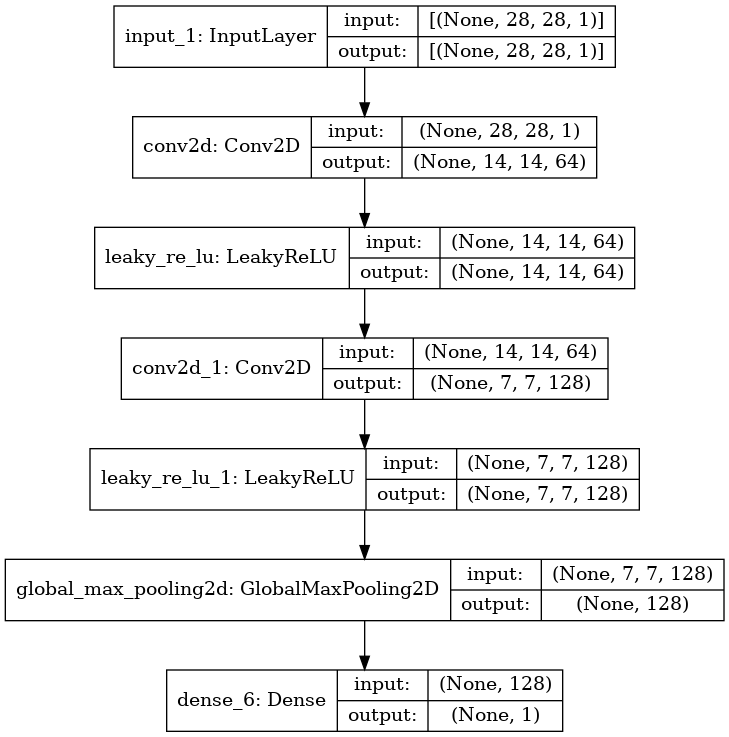

time: 395 ms (started: 2021-08-25 23:33:20 +08:00)


In [25]:
keras.utils.plot_model(discriminator, show_shapes=True)

然后让我们创建一个生成器网络，将潜在向量转换为形状为 (28, 28, 1)（代表 MNIST 数字）的输出：

In [27]:
latent_dim = 128

generator = keras.Sequential(
    [
        layers.InputLayer(input_shape=(latent_dim,)),
        # We want to generate 128 coefficients to reshape into a 7x7x128 map
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 6272)              809088    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 28, 28, 128)       0 

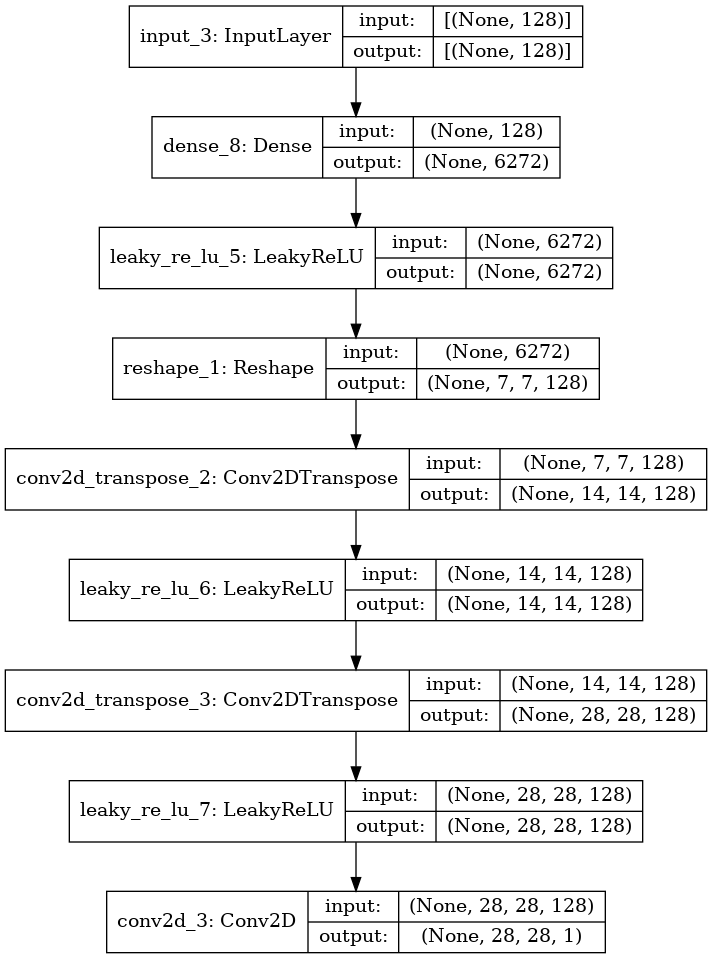

time: 410 ms (started: 2021-08-25 23:36:30 +08:00)


In [28]:
keras.utils.plot_model(generator, show_shapes=True)

这是关键点：训练循环。 如您所见，它非常简单。 训练步骤函数只需要 17 行。

In [29]:
# 为鉴别器实例化一个优化器，为生成器实例化另一个优化器。
d_optimizer = keras.optimizers.Adam(learning_rate=0.0003)
g_optimizer = keras.optimizers.Adam(learning_rate=0.0004)

# 实例化一个损失函数。
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)


@tf.function
def train_step(real_images):
    # 在潜在空间中采样随机点
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    # 将它们解码为假图像
    generated_images = generator(random_latent_vectors)
    # 将它们与真实图像结合
    combined_images = tf.concat([generated_images, real_images], axis=0)

    # 组装区分真假图像的标签
    labels = tf.concat(
        [tf.ones((batch_size, 1)), tf.zeros((real_images.shape[0], 1))], axis=0
    )
    # 向标签添加随机噪声 - 重要技巧！
    labels += 0.05 * tf.random.uniform(labels.shape)

    # 训练判别器
    with tf.GradientTape() as tape:
        predictions = discriminator(combined_images)
        d_loss = loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, discriminator.trainable_weights)
    d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

    # 在潜在空间中采样随机点
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    # 组装标有“所有真实图像”的标签
    misleading_labels = tf.zeros((batch_size, 1))
    
    
    # 训练生成器（注意我们不应该*更新鉴别器的权重）！
    with tf.GradientTape() as tape:
        predictions = discriminator(generator(random_latent_vectors))
        g_loss = loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, generator.trainable_weights)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
    return d_loss, g_loss, generated_images

time: 3.94 ms (started: 2021-08-25 23:48:50 +08:00)


让我们通过对批量图像重复调用 train_step 来训练我们的 GAN。

由于我们的判别器和生成器是 convnets，你会想要在 GPU 上运行这段代码。

In [ ]:
import os

# 准备数据集。 我们同时使用训练和测试 MNIST 数字。
batch_size = 64
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

epochs = 20  # 在实践中，你至少需要 20 个 epoch 才能生成好的数字。
save_dir = "./"

for epoch in range(epochs):
    print("\nStart epoch", epoch)

    for step, real_images in enumerate(dataset):
        # 在一批真实图像上训练鉴别器和生成器。
        d_loss, g_loss, generated_images = train_step(real_images)

        # 记录。
        if step % 200 == 0:
            # 打印指标
            print("discriminator loss at step %d: %.2f" % (step, d_loss))
            print("adversarial loss at step %d: %.2f" % (step, g_loss))

            # 保存一张生成的图片
            img = tf.keras.preprocessing.image.array_to_img(
                generated_images[0] * 255.0, scale=False
            )
            img.save(os.path.join(save_dir, "generated_img" + str(step) + ".png"))

            
        # 为了限制执行时间，我们在 10 步后停止。
        # 删除下面的行以实际训练模型！
#         if step > 10:
#             break


Start epoch 0
discriminator loss at step 0: 0.41
adversarial loss at step 0: 1.44
discriminator loss at step 200: 0.43
adversarial loss at step 200: 1.69
discriminator loss at step 400: 0.22
adversarial loss at step 400: 2.48
discriminator loss at step 600: 0.28
adversarial loss at step 600: 2.28
discriminator loss at step 800: 0.16
adversarial loss at step 800: 3.04
discriminator loss at step 1000: 0.10
adversarial loss at step 1000: 3.23

Start epoch 1
discriminator loss at step 0: 0.10
adversarial loss at step 0: 3.78
discriminator loss at step 200: 0.10
adversarial loss at step 200: 3.40
discriminator loss at step 400: 0.06
adversarial loss at step 400: 4.32
discriminator loss at step 600: 0.06
adversarial loss at step 600: 3.41
discriminator loss at step 800: 0.56
adversarial loss at step 800: 2.00
discriminator loss at step 1000: 0.67
adversarial loss at step 1000: 0.76

Start epoch 2
discriminator loss at step 0: 0.58
adversarial loss at step 0: 1.23
discriminator loss at step 

就是这样！ 在 Colab GPU 上训练约 30 秒后，您将获得漂亮的假 MNIST 数字。